## Basic Pipeline for image processing of our CNN 

### Import Libraries

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os

In [5]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.callbacks import EarlyStopping

In [125]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.math import confusion_matrix

In [7]:
from sklearn.model_selection import train_test_split

### Import Images 

In [ ]:
img = load_img('../raw_data/Dataset/without_mask/1.png')
np.array(img)

In [ ]:
plt.imshow(img)

In [ ]:
img_array = np.array(img)

In [ ]:
img_array.shape

Load no mask data into a np.array for a small test

In [ ]:
X = []
y = []
path = '../raw_data/Dataset/without_mask/'
#path = '/Users/marchiggins/code/Marchigginsberlin/face_mask_detection/raw_data/Dataset/without_mask/'
for i in range(1,2001):
        c_path = os.path.join(path, f'{i}.png')
        X.append(plt.imread(c_path)[:, :, :])
        y.append(0)

Load mask data into a np.array for a small test

In [ ]:
path = '../raw_data/Dataset/mask_weared_incorrect/'
#path = '/Users/marchiggins/code/Marchigginsberlin/face_mask_detection/raw_data/Dataset/without_mask/'
for i in range(1,2001):
        c_path = os.path.join(path, f'{i}.png')
        X.append(plt.imread(c_path)[:, :, :])
        y.append(1)
c = list(zip(X, y))
X, y = zip(*c)
X = np.array(X) 
y = np.array(y)

In [ ]:
y.shape

In [ ]:
X.max()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.20, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                            test_size=0.20, random_state=42)

In [ ]:
X_train.shape

### Import for a large model form folder

In [ ]:
ds_train = image_dataset_from_directory(
    '../raw_data/Dataset/',
    labels = 'inferred',
    label_mode = 'int',
    class_names = ['mask_weared_incorrect','with_mask', 'without_mask'],
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (128, 128),
    shuffle = True,
    seed = 123,
    validation_split = 0.2, 
    subset = 'training')

In [ ]:
ds_validation = image_dataset_from_directory(
    '../raw_data/Dataset/',
    labels = 'inferred',
    label_mode = 'int',
    class_names = ['mask_weared_incorrect','with_mask', 'without_mask'],
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (128, 128),
    shuffle = True,
    seed = 123,
    validation_split = 0.2, 
    subset = 'validation')

In [ ]:
ds_validation

### Import for large model with csv

In [8]:
import tensorflow as tf 

#### Create Dataframe of Data 

In [102]:
directory_no_mask = '../raw_data/Dataset/without_mask/'

no_mask_names = os.listdir('../raw_data/Dataset/without_mask/')

no_mask_df = pd.DataFrame()
no_mask_df['file_name'] = pd.DataFrame(no_mask_names)
no_mask_df['file_name'] = directory_no_mask + no_mask_df['file_name']
no_mask_df['label_0'] = 1

In [103]:
no_mask_df.shape

(2994, 2)

In [104]:
directory_wrong_mask = '../raw_data/Dataset/mask_weared_incorrect/'

wrong_mask_names = os.listdir('../raw_data/Dataset/mask_weared_incorrect/')

wrong_mask_df = pd.DataFrame()
wrong_mask_df['file_name'] = pd.DataFrame(no_mask_names)
wrong_mask_df['file_name'] = directory_wrong_mask + wrong_mask_df['file_name']
wrong_mask_df['label_1'] = 1

In [105]:
wrong_mask_df.shape

(2994, 2)

In [107]:
directory_with_mask = '../raw_data/Dataset/with_mask/'

with_mask_names = os.listdir('../raw_data/Dataset/with_mask/')

with_mask_df = pd.DataFrame()
with_mask_df['file_name'] = pd.DataFrame(no_mask_names)
with_mask_df['file_name'] = directory_without_mask + without_mask_df['file_name']
with_mask_df['label_2'] = 1

In [108]:
without_mask_df.shape

(2994, 2)

In [109]:
df = pd.concat([no_mask_df,wrong_mask_df,without_mask_df],)
df = df.replace(np.nan, 0)

In [110]:
df.shape

(8982, 4)

In [111]:
df.head()

,file_name,label_0,label_1,label_2
0,../raw_data/Dataset/without_mask/348.png,1.0,0.0,0.0
1,../raw_data/Dataset/without_mask/1804.png,1.0,0.0,0.0
2,../raw_data/Dataset/without_mask/1810.png,1.0,0.0,0.0
3,../raw_data/Dataset/without_mask/1186.png,1.0,0.0,0.0
4,../raw_data/Dataset/without_mask/412.png,1.0,0.0,0.0


#### Create Train, Test, Val Set 

In [169]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0], df.iloc[:,1:], test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [182]:
def read_img(image_file, label):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_image(image, channels = 3, dtype = tf.float32)
    image = tf.image.resize_with_pad(image, 224, 224)
     #image = image / 255.
    return image, label 

In [183]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train.values , y_train.values))
ds_train = ds_train.map(read_img).batch(32)

In [184]:
ds_val = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
ds_val = ds_val.map(read_img).batch(32)

In [185]:
ds_test = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
ds_test = ds_test.map(read_img).batch(32)

### Agumentation for Images (Just in Case)

### Scale the Images

In [91]:
# not necessary with the current image import
#X.scaled = X / 255

### Built a basic CNN just like in class

In [148]:
model = models.Sequential()

model.add(layers.Conv2D(6, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=(224, 224, 3)))
model.add(layers.Conv2D(4, kernel_size=(3), padding='valid', activation='relu')) # kernel_size = 3 <==> (3, 3)
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax')) 

model.summary() 

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 6)       168       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 220, 220, 4)       220       
_________________________________________________________________
flatten_8 (Flatten)          (None, 193600)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 580803    
Total params: 581,191
Trainable params: 581,191
Non-trainable params: 0
_________________________________________________________________


In [149]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [150]:
es = EarlyStopping(patience=3, restore_best_weights=True)

In [151]:
model.fit(ds_train, epochs = 10, validation_data = ds_val, callbacks = [es])

Epoch 1/10
203/203 [==============================] - 73s 356ms/step - loss: 0.7939 - accuracy: 0.6075 - val_loss: 0.5168 - val_accuracy: 0.6245
Epoch 2/10
203/203 [==============================] - 71s 348ms/step - loss: 0.5498 - accuracy: 0.6409 - val_loss: 0.5327 - val_accuracy: 0.5744
Epoch 3/10
203/203 [==============================] - 70s 347ms/step - loss: 0.5312 - accuracy: 0.6528 - val_loss: 0.5507 - val_accuracy: 0.5480
Epoch 4/10
203/203 [==============================] - 71s 351ms/step - loss: 0.5170 - accuracy: 0.6687 - val_loss: 0.5736 - val_accuracy: 0.5410


In [152]:
model.evaluate(ds_test, verbose=0)

[0.5535411834716797, 0.5937674045562744]

### Transfer learning with a suitable network

In [203]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

#### MobileNetV2

In [248]:
base_model_1 = MobileNetV2(weights="imagenet", include_top=False,input_shape = (224,224,3)) 
base_model_1.trainable = False


In [249]:
pooling = layers.MaxPool2D(pool_size=(2,2))
flatten_layer = layers.Flatten()
dense_1 = layers.Dense(128, activation="relu")
drop_1 = layers.Dropout(0.5)
prediction_1 = layers.Dense(3, activation="softmax")

In [250]:
model1 = models.Sequential([
    base_model_1,
    pooling, 
    flatten_layer,
    dense_1,
    drop_1,
    prediction_1
])

In [251]:
model1.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 11520)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               1474688   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 387       
Total params: 3,733,059
Trainable params: 1,475,075
Non-trainable params: 2,257,984
___________________________________

In [252]:
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [253]:
history_1 = model1.fit(ds_train, epochs = 10, validation_data = ds_val, callbacks = [es])

Epoch 1/10
203/203 [==============================] - 131s 634ms/step - loss: 0.8337 - accuracy: 0.6407 - val_loss: 0.4913 - val_accuracy: 0.6648
Epoch 2/10
203/203 [==============================] - 142s 700ms/step - loss: 0.5273 - accuracy: 0.6519 - val_loss: 0.4715 - val_accuracy: 0.6773
Epoch 3/10
203/203 [==============================] - 138s 682ms/step - loss: 0.5201 - accuracy: 0.6523 - val_loss: 0.4626 - val_accuracy: 0.6662
Epoch 4/10
203/203 [==============================] - 137s 676ms/step - loss: 0.5093 - accuracy: 0.6543 - val_loss: 0.4653 - val_accuracy: 0.6648
Epoch 5/10
203/203 [==============================] - 136s 669ms/step - loss: 0.5027 - accuracy: 0.6599 - val_loss: 0.4618 - val_accuracy: 0.6718
Epoch 6/10
203/203 [==============================] - 147s 727ms/step - loss: 0.4933 - accuracy: 0.6641 - val_loss: 0.4607 - val_accuracy: 0.6773
Epoch 7/10
203/203 [==============================] - 165s 812ms/step - loss: 0.4933 - accuracy: 0.6564 - val_loss: 0.4640 -

In [254]:
model1.evaluate(ds_test)

57/57 [==============================] - 36s 631ms/step - loss: 0.4663 - accuracy: 0.6533


[0.46629592776298523, 0.6533110737800598]

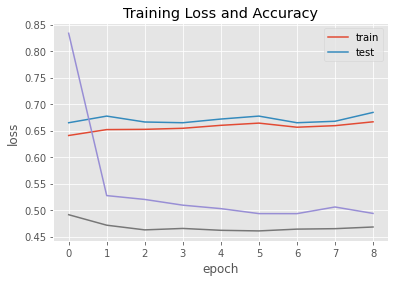

In [262]:
# Fit the model
# list all data in history
# summarize history for accuracy
plt.title("Training Loss and Accuracy")
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

#### NASNetMobile

In [33]:
from tensorflow.keras.applications import NASNetMobile

In [197]:
base_model_2 = NASNetMobile(
    input_shape= None,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,)
base_model.trainable = False
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_2068 (Activation)    (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

separable_conv_1_normal_left1_9 (None, 7, 7, 176)    35376       activation_2209[0][0]            
__________________________________________________________________________________________________
separable_conv_1_normal_right1_ (None, 7, 7, 176)    32560       activation_2211[0][0]            
__________________________________________________________________________________________________
separable_conv_1_normal_left2_9 (None, 7, 7, 176)    35376       activation_2213[0][0]            
__________________________________________________________________________________________________
separable_conv_1_normal_right2_ (None, 7, 7, 176)    32560       activation_2215[0][0]            
__________________________________________________________________________________________________
separable_conv_1_normal_left5_9 (None, 7, 7, 176)    32560       activation_2217[0][0]            
__________________________________________________________________________________________________
separable_

In [198]:
dense_layer = layers.Dense(500, activation = 'relu')
prediction_layer = layers.Dense(3, activation = 'softmax')

model2 = models.Sequential([
    base_model_2, 
    prediction_layer
])

In [200]:
model2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 1000)              5326716   
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 3003      
Total params: 5,329,719
Trainable params: 3,003
Non-trainable params: 5,326,716
_________________________________________________________________


In [201]:
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [202]:
model2.fit(ds_train, epochs = 10, validation_data = ds_val, callbacks = [es])

Epoch 1/10
203/203 [==============================] - 181s 847ms/step - loss: 1.0694 - accuracy: 0.5368 - val_loss: 1.0440 - val_accuracy: 0.5883
Epoch 2/10
203/203 [==============================] - 182s 895ms/step - loss: 1.0249 - accuracy: 0.5728 - val_loss: 1.0032 - val_accuracy: 0.5981
Epoch 3/10
203/203 [==============================] - 184s 907ms/step - loss: 0.9871 - accuracy: 0.5779 - val_loss: 0.9684 - val_accuracy: 0.5967
Epoch 4/10
203/203 [==============================] - 183s 900ms/step - loss: 0.9546 - accuracy: 0.5823 - val_loss: 0.9387 - val_accuracy: 0.5981
Epoch 5/10
203/203 [==============================] - 190s 934ms/step - loss: 0.9266 - accuracy: 0.5852 - val_loss: 0.9129 - val_accuracy: 0.5994
Epoch 6/10
203/203 [==============================] - 192s 947ms/step - loss: 0.9022 - accuracy: 0.5899 - val_loss: 0.8905 - val_accuracy: 0.6022
Epoch 7/10
203/203 [==============================] - 197s 968ms/step - loss: 0.8809 - accuracy: 0.5908 - val_loss: 0.8709 -

In [195]:
model2.evaluate(ds_test)

57/57 [==============================] - 42s 729ms/step - loss: 0.5263 - accuracy: 0.5971


[0.5263108015060425, 0.5971062779426575]

In [ ]:
[0.5263108015060425, 0.5971062779426575]

In [240]:
prediction_m2 = model2.predict(ds_test)

In [241]:
from tensorflow.math import confusion_matrix

In [243]:
confusion_matrix(y_test, prediction_m2)

InvalidArgumentError: Dimensions [0,2) of indices[shape=[1797,2,3]] must match dimensions [0,2) of updates[shape=[1797,3]] [Op:ScatterNd]